# Laboratorio 4
## Mejorando el Análisis de Sentimientos con LSTM y Características Adicionales
- Mark Albrand 21004
- Jimena Hernández 21199

In [411]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from textblob import TextBlob


### Importación

In [412]:
max_features = 50000 #50,000 palabras más frecuentes

In [413]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# dividir test entre test y validacion (60% test, 40% validacion)
sixty = int(len(X_test) * 0.6)
X_val = X_test[sixty:]
y_val = y_test[sixty:]
X_test = X_test[:sixty]
y_test = y_test[:sixty]

In [414]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print(len(X_val), 'validation sequences')

25000 train sequences
15000 test sequences
10000 validation sequences


In [415]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

### Preprocesamiento

#### Exploración de Datos

In [416]:
word_index = imdb.get_word_index()
word_index_inv = {v: k for k, v in word_index.items()}

In [417]:
for w in X_train[0]:
    print(word_index_inv.get(w - 3, '?'), end=' ')

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

In [418]:
for i in range(10):
    for w in X_train[i]:
        print(word_index_inv.get(w-3, '?'), end=' ')
    print()

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

In [419]:
for w in word_index_inv:
    print(word_index_inv[w])

fawn
tsukino
nunnery
sonja
vani
woods
spiders
hanging
woody
trawling
hold's
comically
localized
disobeying
'royale
harpo's
canet
aileen
acurately
diplomat's
rickman
arranged
rumbustious
familiarness
spider'
hahahah
wood'
transvestism
hangin'
bringing
seamier
wooded
bravora
grueling
wooden
wednesday
'prix
altagracia
circuitry
crotch
busybody
tart'n'tangy
burgade
thrace
tom's
snuggles
francesco
complainers
templarios
272
273
zaniacs
275
consenting
snuggled
inanimate
uality
bronte
errors
dialogs
yomada's
madman's
dialoge
usenet
videodrome
kid'
pawed
'girlfriend'
'pleasure
'reloaded'
kazakos'
rocque
mailings
brainwashed
mcanally
tom''
kurupt
affiliated
babaganoosh
noe's
quart
kids
uplifting
controversy
kida
kidd
error'
neurologist
spotty
cobblers
projection
fastforwarding
sters
eggar's
etherything
gateshead
airball
unsinkable
stern
cervi's
dnd
dna
insecurity
'reboot'
trelkovsky
jaekel
sidebars
sforza's
distortions
mutinies
sermons
7ft
boobage
o'bannon's
populations
chulak
mesmerize
quinnel

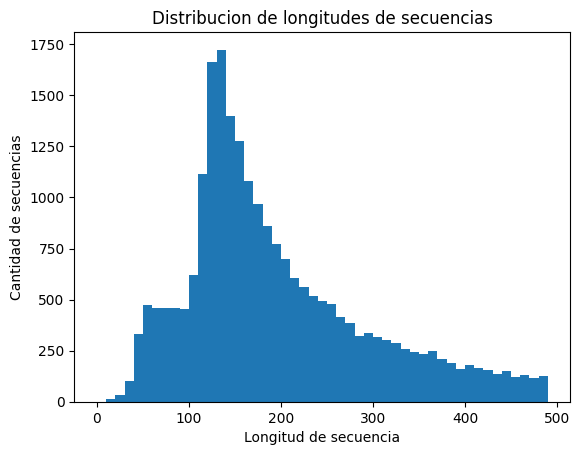

In [420]:
lengths = [len(x) for x in X_train]
plt.hist(lengths, bins=range(0, 500, 10))
plt.title('Distribucion de longitudes de secuencias')
plt.xlabel('Longitud de secuencia')
plt.ylabel('Cantidad de secuencias')
plt.show()


#### Limpieza de texto

In [421]:
# eliminar palabras que no estan en el diccionario
X_train = [[w for w in x if word_index_inv.get(w - 3, '?') != '?' ] for x in X_train]
X_val = [[w for w in x if word_index_inv.get(w - 3, '?') != '?' ] for x in X_val]
X_test = [[w for w in x if word_index_inv.get(w - 3, '?') != '?' ] for x in X_test]

for i in range(10):
    for w in X_train[i]:
        print(word_index_inv.get(w-3, '?'), end=' ')
    print()

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be p

In [422]:
for w in X_train[0]:
    print(word_index_inv.get(w - 3, '?'), end=' ')

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be p

In [423]:
positive_words = []
negative_words = []
neutral_words = []

# text blob
for w in word_index_inv:
    blob = TextBlob(word_index_inv[w])

    sentiment = blob.sentiment  # (polarity, subjectivity)

    if sentiment[0] > 0.3:
        print("Positivo", word_index_inv[w], sentiment)
        positive_words.append(w)

    if sentiment[0] < -0.3:
        print("Negativo", word_index_inv[w], sentiment)
        negative_words.append(w)

    if sentiment[0] == 0:
        neutral_words.append(w)

Positivo comically Sentiment(polarity=0.5, subjectivity=1.0)
Positivo expressively Sentiment(polarity=0.8, subjectivity=1.0)
Positivo mostand Sentiment(polarity=0.5, subjectivity=0.5)
Negativo wrong Sentiment(polarity=-0.5, subjectivity=0.9)
Positivo fit Sentiment(polarity=0.4, subjectivity=0.4)
Negativo sickeningly Sentiment(polarity=-0.9, subjectivity=1.0)
Negativo nasty' Sentiment(polarity=-1.0, subjectivity=1.0)
Positivo nicely Sentiment(polarity=0.6, subjectivity=1.0)
Positivo inventively Sentiment(polarity=0.5, subjectivity=1.0)
Positivo good' Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
Positivo celebrated Sentiment(polarity=0.35, subjectivity=0.75)
Positivo convincingly Sentiment(polarity=0.5, subjectivity=1.0)
Positivo workmanlike Sentiment(polarity=0.5, subjectivity=0.7)
Negativo seriously Sentiment(polarity=-0.3333333333333333, subjectivity=0.6666666666666666)
Negativo raunchy Sentiment(polarity=-0.5, subjectivity=1.0)
Positivo 'good Sentiment(polarity=0.7, subj

In [424]:
print("Positivos", len(positive_words))
print("Negativos", len(negative_words))
print("Neutrales", len(neutral_words))

print("Positivos", [word_index_inv[w] for w in positive_words[:10]])
print("Negativos", [word_index_inv[w] for w in negative_words[:10]])
print("Neutrales", [word_index_inv[w] for w in neutral_words[:10]])

Positivos 735
Negativos 631
Neutrales 86222
Positivos ['comically', 'expressively', 'most\x85and', 'fit', 'nicely', 'inventively', "good'", 'celebrated', 'convincingly', 'workmanlike']
Negativos ['wrong', 'sickeningly', "nasty'", 'seriously', 'raunchy', 'menacing', 'dirty', 'malevolent', 'shocking', 'terrifyingly']
Neutrales ['fawn', 'tsukino', 'nunnery', 'sonja', 'vani', 'woods', 'spiders', 'hanging', 'woody', 'trawling']


In [425]:
max_neutral = 40_000

neutral_words = np.random.choice(neutral_words, max_neutral, replace=False)

print("Neutrales", len(neutral_words))

Neutrales 40000


In [426]:
# sacar las neutrales
X_train = [[w for w in x if w not in neutral_words] for x in X_train]
X_val = [[w for w in x if w not in neutral_words] for x in X_val]
X_test = [[w for w in x if w not in neutral_words] for x in X_test]

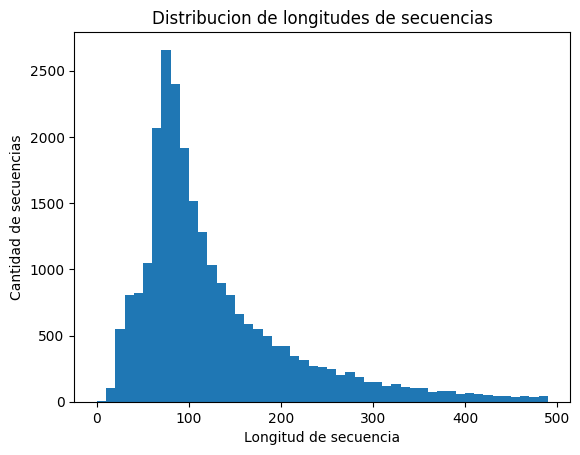

In [427]:
# graficar nuevamente las longitudes
lengths = [len(x) for x in X_train]
plt.hist(lengths, bins=range(0, 500, 10))
plt.title('Distribucion de longitudes de secuencias')
plt.xlabel('Longitud de secuencia')
plt.ylabel('Cantidad de secuencias')
plt.show()

#### Extracción de características adicionales

En este laboratorio, se implementa un modelo de análisis de sentimientos utilizando una red neuronal LSTM. Además, se extraen características adicionales de los textos para mejorar la clasificación de los sentimientos. Se usaran las siguientes características adicionales:

- Número de palabras
- Ratio de palabras positivas
- Ratio de palabras negativas

In [428]:

# Convertir las listas de palabras a índices
positive_indices = [word_index[word] + 3 for word in positive_words if word in word_index and word_index[word] < max_features]
negative_indices = [word_index[word] + 3 for word in negative_words if word in word_index and word_index[word] < max_features]

#Función para extraer características de las secuencias
def extract_features(sequences):
    features = []
    for seq in sequences:
        length = len(seq)  # Longitud de la secuencia
        pos_count = sum(1 for word in seq if word in positive_indices)  # Cantidad de palabras positivas
        neg_count = sum(1 for word in seq if word in negative_indices)  # Cantidad de palabras negativas
        
        pos_ratio = pos_count / length if length > 0 else 0  # Proporción de palabras positivas
        neg_ratio = neg_count / length if length > 0 else 0  # Proporción de palabras negativas
        
        features.append([length, pos_ratio, neg_ratio])  # Se agregan las características a la lista
    return np.array(features)

train_features = extract_features(X_train)  
test_features = extract_features(X_test)  
val_features = extract_features(X_val) 

In [429]:
train_features[0]

array([126.,   0.,   0.])

#### Longitud uniforme
Secuencie y rellene las críticas para que todas tengan una longitud uniforme.

In [430]:
maxlen = 100

In [431]:
X_train = sequence.pad_sequences(X_train, maxlen = maxlen)
X_test = sequence.pad_sequences(X_test, maxlen = maxlen)
X_val = sequence.pad_sequences(X_val, maxlen = maxlen)

In [432]:
print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\nY_train shape: {y_train.shape}\nY_test shape: {y_test.shape}")

X_train shape: (25000, 100)
X_test shape: (15000, 100)
Y_train shape: (25000,)
Y_test shape: (15000,)


#### Unión de características y secuencias 

In [433]:
# Unir las características extraídas con las secuencias
X_train = np.concatenate([X_train, train_features], axis=1)
X_test = np.concatenate([X_test, test_features], axis=1)
X_val = np.concatenate([X_val, val_features], axis=1)

In [434]:
X_train[0]

array([5.000e+01, 1.600e+01, 1.470e+02, 1.900e+01, 1.400e+01, 2.200e+01,
       4.613e+03, 4.690e+02, 2.200e+01, 1.200e+01, 1.600e+01, 3.800e+01,
       7.600e+01, 2.200e+01, 1.200e+01, 1.600e+01, 6.260e+02, 1.800e+01,
       5.000e+00, 6.200e+01, 3.860e+02, 1.200e+01, 8.000e+00, 8.000e+00,
       5.000e+00, 2.223e+03, 1.600e+01, 4.800e+02, 6.600e+01, 1.300e+02,
       1.200e+01, 1.600e+01, 3.800e+01, 6.190e+02, 5.000e+00, 2.500e+01,
       5.100e+01, 3.600e+01, 1.350e+02, 4.800e+01, 2.500e+01, 1.415e+03,
       2.200e+01, 1.200e+01, 5.200e+01, 5.000e+00, 1.400e+01, 1.600e+01,
       8.200e+01, 8.000e+00, 1.070e+02, 1.170e+02, 5.952e+03, 2.560e+02,
       3.105e+04, 5.000e+00, 7.230e+02, 3.600e+01, 2.600e+01, 4.000e+02,
       3.170e+02, 4.600e+01, 1.029e+03, 8.800e+01, 3.810e+02, 2.970e+02,
       3.200e+01, 2.600e+01, 1.940e+02, 1.800e+01, 2.200e+01, 2.100e+01,
       1.340e+02, 2.600e+01, 4.800e+02, 5.000e+00, 1.440e+02, 3.000e+01,
       1.800e+01, 5.100e+01, 3.600e+01, 9.200e+01, 

### Modelo

In [435]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.regularizers import l2

In [436]:
modelo = Sequential()

modelo.add(Embedding(max_features, 128))

modelo.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01)))
modelo.add(Dense(256, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(128, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(1, activation='sigmoid'))

In [437]:
modelo.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### Entrenamiento

In [438]:
history = modelo.fit(
    X_train, y_train,
    batch_size = 32,
    epochs = 4,
    validation_data = (X_val, y_val)
)

Epoch 1/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 81ms/step - accuracy: 0.5653 - loss: 0.9704 - val_accuracy: 0.7947 - val_loss: 0.4918
Epoch 2/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.8035 - loss: 0.4962 - val_accuracy: 0.8054 - val_loss: 0.4847
Epoch 3/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.8367 - loss: 0.4449 - val_accuracy: 0.8009 - val_loss: 0.4905
Epoch 4/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.8527 - loss: 0.4184 - val_accuracy: 0.8242 - val_loss: 0.4330


In [439]:
#modelo.save("Anal_Sentimiento.h5")

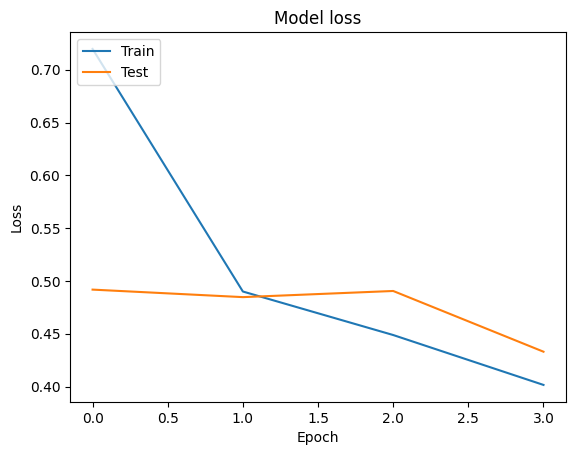

In [440]:
# Graficar loss y val_loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

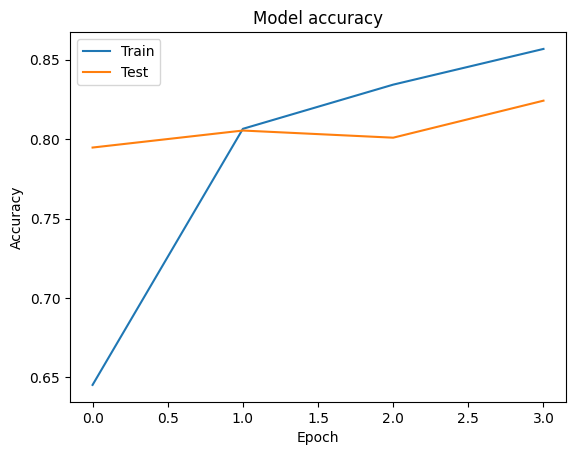

In [441]:
# Graficar accuracy y val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [442]:
# from tensorflow.keras.models import load_model
# modelo = load_model("Anal_Sentimiento.h5")

### Evaluación

In [443]:
perdida, exactitud = modelo.evaluate(
    X_test, y_test,
    batch_size = 32,
    verbose = 2
)

print('Pérdida de la Prueba:', perdida)
print('Exactitud de la Prueba (Test accuracy):', exactitud)

469/469 - 8s - 17ms/step - accuracy: 0.8229 - loss: 0.4448
Pérdida de la Prueba: 0.44478437304496765
Exactitud de la Prueba (Test accuracy): 0.8229333162307739


In [444]:
from sklearn.metrics import classification_report

y_pred = modelo.predict(X_test)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred))

469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      7527
           1       0.84      0.79      0.82      7473

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



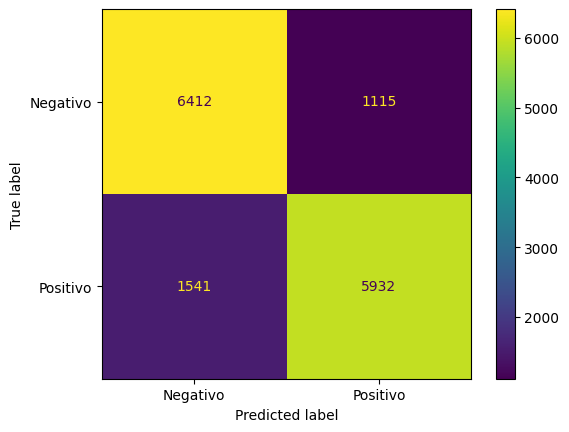

In [445]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativo', 'Positivo'])
disp.plot()